In [1]:
# import libraries / dependencies

from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

from api_keys import censuskey, gmaps_key
from census import Census
from us import states

# Deaths in Police Custody in CA, 2005-2018
Source: https://openjustice.doj.ca.gov/data 

In [2]:
# import the csv
# dtype : Type name or dict of column -> type, default None
#    Data type for data or columns. E.g. {'a': np.float64, 'b': np.int32}

dic_import = pd.read_excel(r'../Resources/DIC/DIC_2005-2018_20190612.xlsx', dtype="string", sheet_name='2005-2018')
dic_import

# eventually filter by custody_status and/or custodial_responsibilty_at_time_of_death
# combine the date columns into one
# Pending Investigation? Seems suspicious
# how could you map the custody_offense code to the offense (string)

,record_key_number,reporting_agency,agency_number,agency_full_name,county,race,gender,age,custody_status,custody_offense,date_of_death_yyyy,date_of_death_mm,date_of_death_dd,custodial_responsibilty_at_time_of_death,location_where_cause_of_death_occurred,facility_of_death,manner_of_death,means_of_death
0,2005001,State,27025C,Salinas Valley State Prison,Monterey,Other,Male,35,Sentenced,110,2005,01,03,CDC/CRC,Living,CDC/CRC,Suicide,"Hanging,Strangulation"
1,2005002,Police,390200,Lodi Police Department,San Joaquin,White,Male,67,Awaiting Booking,046,2005,01,05,City Jail,Living,City Jail,Natural,Not Applicable
2,2005003,State,48015C,California Medical Facility,Solano,White,Male,51,Sentenced,110,2005,01,06,CDC/CRC,Not Applicable,CDC/CRC,Natural,Not Applicable
3,2005004,State,15025C,Wasco State Prison,Kern,Hispanic,Male,50,Sentenced,501,2005,01,06,CDC/CRC,Not Applicable,Local Hospital,Natural,Not Applicable
4,2005005,State,34065C,"California State Prison, Sacramento",Sacramento,White,Male,53,Sentenced,800,2005,01,09,CDC/CRC,Not Applicable,Local Hospital,Natural,Not Applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9906,2018787,Sheriff,330000,Riverside County Sheriff's Department,Riverside,Hispanic,Male,35,Process of Arrest,300,2018,12,20,Process of Arrest,Crime/Arrest Scene,Local Hospital,Pending Investigation,Pending Investigation
9907,2018788,Sheriff,330000,Riverside County Sheriff's Department,Riverside,Hispanic,Male,59,Process of Arrest,320,2018,12,20,Process of Arrest,Crime/Arrest Scene,Local Hospital,Pending Investigation,Pending Investigation
9908,2018789,State,03035C,Mule Creek State Prison,Amador,Black,Male,67,Sentenced,700,2018,12,31,CDC/CRC,Living,CDC/CRC,Natural,Not Applicable
9909,2018790,Police,480700,Vallejo Police Department,Solano,Black,Male,33,Process of Arrest,341,2018,02,13,Process of Arrest,Crime/Arrest Scene,Crime/Arrest Scene,Homicide Justified (Law Enforcement Staff),Handgun


In [3]:
# CLEAN - combine the three date columns into one

dic_import["date_of_passing"] = dic_import["date_of_death_yyyy"].astype(str) + "/" + dic_import["date_of_death_mm"].astype(str) + "/" + dic_import["date_of_death_dd"].astype(str)




In [4]:
# update the df to drop the now obsolete singular date columns (month, day) + others

dic_drop = dic_import.drop(columns=["date_of_death_mm", "date_of_death_dd", ])

In [5]:
# rearrange the column order so that passing date is not at the end

dic_reorder = dic_drop[["record_key_number", "reporting_agency", "agency_number", "agency_full_name", "county", "race", "gender", "age", "date_of_death_yyyy", "date_of_passing", "custody_status", "custody_offense", "custodial_responsibilty_at_time_of_death", "location_where_cause_of_death_occurred", "facility_of_death", "manner_of_death", "means_of_death"]]

In [6]:
# find the unique values in the custody_status column

print(dic_reorder.custody_status.unique())
print(dic_reorder.age.value_counts())

<StringArray>
[                'Sentenced',          'Awaiting Booking',
   'Booked - Awaiting Trial', 'Booked - No Charges Filed',
                     'Other',                'In Transit',
         'Process of Arrest',              'Out to Court']
Length: 8, dtype: string
53     269
51     262
55     247
48     245
57     245
      ... 
96       2
Unk      1
13       1
92       1
97       1
Name: age, Length: 85, dtype: Int64


# "Low-income folks = less likely to afford bail, 
meaning the bulk of America’s jailed population is made up of people 
whose incarceration stems from being poor. 
People in jail are more likely to plead guilty, studies show, 
because it’s typically the fastest track to getting home. 
By design, plea bargains are supposed to be a way of avoiding lengthy, 
costly trials for defendants who are clearly guilty. 
Instead, they’ve become a way for low-income people to get out of jail 
as quickly as possible, 
even if it means pleading guilty to a crime they didn’t commit."

In [7]:
# filter out the 'sentenced' status - innocent until proven guilty
# this means these people were killed by police without having been convicted of any crime

# another thing you could do later
# --> find averages/assumptions for people wrongly incarcerated and extrapolate
# --> 97% - percentage of federal criminal convictions that result from guilty pleas instead of trials.

innocent_until_proven = dic_reorder.loc[(dic_reorder.custody_status != 'Sentenced') ,:]
innocent_until_proven

,record_key_number,reporting_agency,agency_number,agency_full_name,county,race,gender,age,date_of_death_yyyy,date_of_passing,custody_status,custody_offense,custodial_responsibilty_at_time_of_death,location_where_cause_of_death_occurred,facility_of_death,manner_of_death,means_of_death
1,2005002,Police,390200,Lodi Police Department,San Joaquin,White,Male,67,2005,2005/01/05,Awaiting Booking,046,City Jail,Living,City Jail,Natural,Not Applicable
9,2005010,Sheriff,090000,El Dorado County Sheriff's Department,El Dorado,White,Male,46,2005,2005/01/11,Booked - Awaiting Trial,100,County Jail,Living,Local Hospital,Natural,Not Applicable
21,2005022,Sheriff,370000,San Diego County Sheriff's Department,San Diego,White,Female,46,2005,2005/01/24,Awaiting Booking,516,Other,Other,Local Hospital,Accidental,Drug Overdose
25,2005026,Sheriff,190000,Los Angeles County Sheriff's Department,Los Angeles,Black,Male,49,2005,2005/01/10,Booked - Awaiting Trial,320,County Jail,Not Applicable,Local Hospital,Natural,Not Applicable
28,2005029,Sheriff,190000,Los Angeles County Sheriff's Department,Los Angeles,Black,Male,56,2005,2005/01/20,Booked - Awaiting Trial,822,County Jail,Not Applicable,Local Hospital,Natural,Not Applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,2018784,Sheriff,190000,Los Angeles County Sheriff's Department,Los Angeles,White,Male,42,2018,2018/12/07,Process of Arrest,323,Process of Arrest,Crime/Arrest Scene,Local Hospital,Pending Investigation,Pending Investigation
9905,2018786,Sheriff,330000,Riverside County Sheriff's Department,Riverside,White,Female,33,2018,2018/12/19,Process of Arrest,300,Process of Arrest,Crime/Arrest Scene,Crime/Arrest Scene,Pending Investigation,Pending Investigation
9906,2018787,Sheriff,330000,Riverside County Sheriff's Department,Riverside,Hispanic,Male,35,2018,2018/12/20,Process of Arrest,300,Process of Arrest,Crime/Arrest Scene,Local Hospital,Pending Investigation,Pending Investigation
9907,2018788,Sheriff,330000,Riverside County Sheriff's Department,Riverside,Hispanic,Male,59,2018,2018/12/20,Process of Arrest,320,Process of Arrest,Crime/Arrest Scene,Local Hospital,Pending Investigation,Pending Investigation


In [8]:
# race - compare to county/state demographic percentage
# would this be best done by linking to the census API?
# do this once you have totals - groupby
# check dtypes

# just remove the unknown value in this instance because only one row shows an unknown age

innocent_until_proven = innocent_until_proven[innocent_until_proven.age != 'Unk']


# 2 ways to deal with unknown -- are the unknowns important to me or not? 
# will they change the distribution? --> something like miliseconds is significant
# if they matter, figure out what to replace them with -- average of the values
# this is where stats plays a big role! if the data is skewed, median may be better than mean
# if there is a normal distribution of the data, then mean would make sense
# do I have to replace them all? or should I segregate the male vs. female
# input median for male, median for female
# you can further drill down by county, race, etc...the further you go, the more specific you will get

In [9]:
# .info --> what are the columns? what are the datatypes of the columns? how many null values?
# then do df.value_counts() -- unique elements within that column
# df['age'].describe -- describe the numberical data
innocent_until_proven.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3754 entries, 1 to 9909
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   record_key_number                         3754 non-null   string
 1   reporting_agency                          3754 non-null   string
 2   agency_number                             3754 non-null   string
 3   agency_full_name                          3754 non-null   string
 4   county                                    3754 non-null   string
 5   race                                      3754 non-null   string
 6   gender                                    3754 non-null   string
 7   age                                       3754 non-null   string
 8   date_of_death_yyyy                        3754 non-null   string
 9   date_of_passing                           3754 non-null   object
 10  custody_status                            3754 n

In [10]:
innocent_until_proven['date_of_passing'] =  pd.to_datetime(innocent_until_proven['date_of_passing'], dayfirst=True, exact=False, infer_datetime_format=True)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
innocent_until_proven['age'] = innocent_until_proven['age'].astype(int)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
# not a fan of grouping diverse groups into an "other" category
# but for purposes of analysis this dataset will look closely at the 3 largest ethnic groups in CA (as they relate to arrest data)
# 3 largest --> White, Latinx, Black

innocent_til_proven = innocent_until_proven.replace(['American Indian', 'Asian Indian', 'Cambodian', 
                               'Chinese', 'Filipino', 'Hawaiian', 'Japanese', 'Korean', 
                               'Laotian', 'Other Asian', 'Pacific Islander', 'Samoan', 'Vietnamese'], 'Other')

In [13]:
race_totals = innocent_until_proven.race.value_counts()

# Create a group based on the values in the 'maker' column
race_group = innocent_until_proven.groupby('race')

# Count how many times each maker appears in our group
race_count = race_group['race'].count()

race_count

race
American Indian       20
Asian Indian          16
Black                753
Cambodian              5
Chinese               10
Filipino              21
Hawaiian               1
Hispanic            1354
Japanese               3
Korean                 9
Laotian                4
Other                 60
Other Asian           38
Pacific Islander      16
Samoan                 5
Vietnamese            25
White               1414
Name: race, dtype: int64

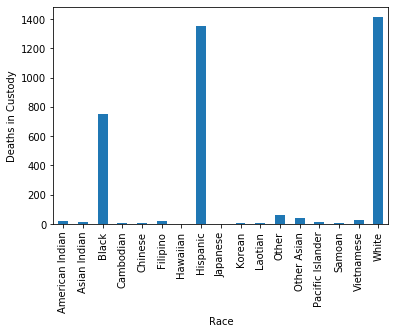

<Figure size 432x288 with 0 Axes>

In [14]:
# Create a bar chart based off of the group series from before
count_chart = race_count.plot(kind='bar')

# Set the xlabel and ylabel using class methods
count_chart.set_xlabel("Race")
count_chart.set_ylabel("Deaths in Custody")


plt.show()
plt.tight_layout()

In [15]:
# create separate dfs to get the totals for each year
# you can probably write a for loop to execute the code below as well but not a priority rn

df_05 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2005'), :]
df_06 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2006'), :]
df_07 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2007'), :]
df_08 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2008'), :]
df_09 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2009'), :]
df_10 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2010'), :]
df_11 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2011'), :]
df_12 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2012'), :]
df_13 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2013'), :]
df_14 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2014'), :]
df_15 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2015'), :]
df_16 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2016'), :]
df_17 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2017'), :]
df_18 = innocent_til_proven.loc[(innocent_til_proven.date_of_death_yyyy == '2018'), :]

In [16]:
# get the death count by race to be used in a bar graph

totals_05 = df_05.race.value_counts()
totals_06 = df_06.race.value_counts()
totals_07 = df_07.race.value_counts()
totals_08 = df_08.race.value_counts()
totals_09 = df_09.race.value_counts()
totals_10 = df_10.race.value_counts()
totals_11 = df_11.race.value_counts()
totals_12 = df_12.race.value_counts()
totals_13 = df_13.race.value_counts()
totals_14 = df_14.race.value_counts()
totals_15 = df_15.race.value_counts()
totals_16 = df_16.race.value_counts()
totals_17 = df_17.race.value_counts()
totals_18 = df_18.race.value_counts()


print(innocent_til_proven.race.unique())
print(totals_17)

# you're going to need to relabel the racial groups so that they can map identically for the graph
# --> white, black, hispanic, other

<StringArray>
['White', 'Black', 'Hispanic', 'Other']
Length: 4, dtype: string
White       123
Hispanic    114
Black        45
Other        10
Name: race, dtype: Int64


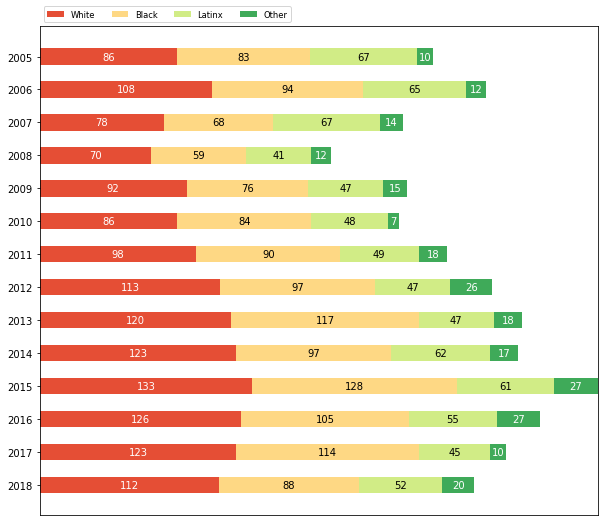

In [17]:
# discrete distribution - horizontal bar chart of deaths per racial group :(
# create a similar graph using census data to show changes in population demographics
# --> we see the total number of deaths decline...something tells me that the CA Black population is also in decline
# we also see a spike in 2015 (Freddie Gray, Sandra Bland) 
# --> the year after Michael Brown, Tamir Rice, Eric Garner...Ferguson (2014)
# --> likely a year with many protests; potentially contributed to elevated deaths under police custody
# --> BLM was founded in 2013 after Trayvon Martin's killer was acquitted

category_names = ['White', 'Black', 'Latinx', 'Other']

annual_deaths = {
    '2005': totals_05, '2006': totals_06, '2007': totals_07, '2008': totals_08, '2009': totals_09,
    '2010': totals_10, '2011': totals_11, '2012': totals_12, '2013': totals_13, '2014': totals_14,
    '2015': totals_15, '2016': totals_16, '2017': totals_17, '2018': totals_18
}

def breakdown(annual_deaths, category_names):
    
    labels = list(annual_deaths.keys())
    data = np.array(list(annual_deaths.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(10, 9))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.3 else 'black'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


breakdown(annual_deaths, category_names)
plt.show()

# add percentage labels?

# Import population data from census

In [18]:
# define census variable

c = Census(censuskey)

In [19]:
# Find CA population demographics by pulling from the census library/API

census_09 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2009)

census_10 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2010)

census_11 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2011)

census_12 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2012)

census_13 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2013)

census_14 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2014)

census_15 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2015)

census_16 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2016)

census_17 = c.acs5.state(("B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
           "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
                         states.CA.fips, year=2017)


# census_18 = c.pep.state(("NAME", "B01003_001E", "B02001_002E", "B02001_003E", "B02001_004E", 
#            "B02001_005E", "B02001_006E", "B02001_008E", "B03001_003E"), 
#                          states.CA.fips, year=2018)

In [20]:
# create dataframes for each annual population breakdown
cens_df_09 = pd.DataFrame(census_09)
cens_df_10 = pd.DataFrame(census_10)
cens_df_11 = pd.DataFrame(census_11)
cens_df_12 = pd.DataFrame(census_12)
cens_df_13 = pd.DataFrame(census_13)
cens_df_14 = pd.DataFrame(census_14)
cens_df_15 = pd.DataFrame(census_15)
cens_df_16 = pd.DataFrame(census_16)
cens_df_17 = pd.DataFrame(census_17)

frames = [cens_df_09, cens_df_10, cens_df_11, cens_df_12, cens_df_13, cens_df_14, cens_df_15, cens_df_16, cens_df_17]

In [21]:
# merge all of the census population data together
# set an index marking each year

census_concat = pd.concat(frames)
census_concat
census_09_17 = census_concat.set_index([pd.Index(['2009', '2010', '2011', '2012', '2013', 
                                                  '2014', '2015', '2016', '2017'])])

#rename the columns
census_ca_pops = census_09_17.rename(columns={"B01003_001E": "total_population",
                                      "B02001_002E": "population_white",
                                      "B02001_003E": "population_black",
                                      "B02001_004E": "population_native",
                                      "B02001_005E": "population_asian",
                                      "B02001_006E": "population_hawaiian_apac", 
                             "B02001_008E": "population_multi",
                            "B03001_003E": "population_latinx"})

# drop the state code column
census_ca_pops = census_ca_pops.drop(columns='state')
census_ca_pops['population_other'] = census_ca_pops.population_native + census_ca_pops.population_asian + census_ca_pops.population_hawaiian_apac + census_ca_pops.population_multi
census_ca_summ = census_ca_pops.drop(columns=['population_native', 'population_asian', 'population_hawaiian_apac', 'population_multi'])


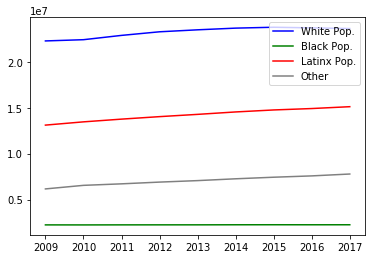

In [22]:
years = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

# Plot each racial demographic as a line chart
white, = plt.plot(years, census_ca_summ.population_white, color="blue", label="White Pop." )

black, = plt.plot(years, census_ca_summ.population_black, color="green", label="Black Pop.")

latinx, = plt.plot(years, census_ca_summ.population_latinx, color="red", label="Latinx Pop.")

other, = plt.plot(years, census_ca_summ.population_other, color="grey", label="Other")

# Create a legend for our chart
plt.legend(handles=[white, black, latinx, other], loc="best")

# Show the chart
plt.show()



In [23]:
census_breakdown = census_ca_summ.drop(columns=['total_population'])

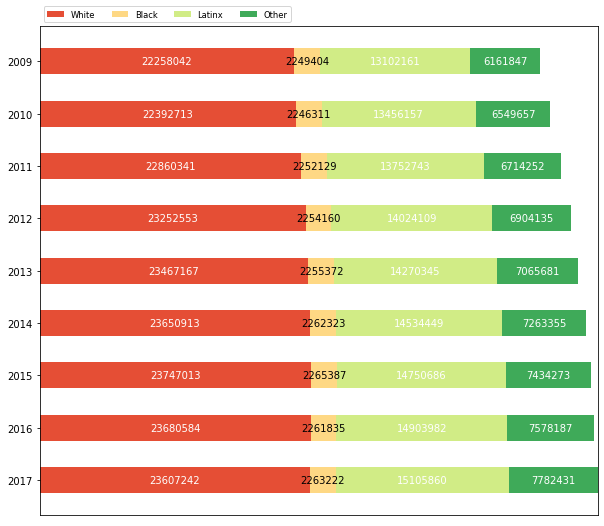

In [24]:
category_names = ['White', 'Black', 'Latinx', 'Other']

annual_pops = {
    '2009': census_breakdown.loc['2009'],
    '2010': census_breakdown.loc['2010'],
    '2011': census_breakdown.loc['2011'],
    '2012': census_breakdown.loc['2012'],
    '2013': census_breakdown.loc['2013'],
    '2014': census_breakdown.loc['2014'],
    '2015': census_breakdown.loc['2015'],
    '2016': census_breakdown.loc['2016'],
    '2017': census_breakdown.loc['2017']
}

def breakdown(annual_pops, category_names):
    
    labels = list(annual_pops.keys())
    data = np.array(list(annual_pops.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(10, 9))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.4 else 'black'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


breakdown(annual_pops, category_names)
plt.show()

In [25]:
# now do you want to combine the annual populations with the death in custody dataset? 
# seems like the logical next step
# or you can keep them as separate tables
# then just clean the column names/datatypes as needed and use sqlalchemy etc to put the final table into a DB
# then move onto county/city budget funding

# also don't forget to convert datatypes from objects to strings

# push these datasets to_csv so you can load them onto pgadmin or something

# County Budget Data

In [26]:
# city_path = "../Resources/budget/City_Expenditures.csv"
county_path = "../Resources/budget/County_-_Expenditures.csv"

# city_upload = pd.read_csv(city_path)
county_upload = pd.read_csv(county_path)

In [27]:
print(county_upload.count())
county_upload.head()

Entity Name             231648
Fiscal Year             231648
Type                    231648
Form/Table              231648
Category                231648
Subcategory 1           231648
Subcategory 2           231648
Line Description        231648
Values                  231648
Zip Code                231648
Estimated Population    231648
Area in Sq. Miles       231648
Row Number              231648
dtype: int64


,Entity Name,Fiscal Year,Type,Form/Table,Category,Subcategory 1,Subcategory 2,Line Description,Values,Zip Code,Estimated Population,Area in Sq. Miles,Row Number
0,Alameda,2017,Expenditures,PERS_SERV,Internal Service Fund,Operating Expenses,Personnel Services_Internal Service Fund,Personnel Services_Internal Service Fund,85254800,94612,1645359,825,201710571644
1,Alameda,2017,Expenditures,CONTRACT_SERV,Internal Service Fund,Operating Expenses,Contractual Services_Internal Service Fund,Contractual Services_Internal Service Fund,14435608,94612,1645359,825,201710571643
2,Alameda,2017,Expenditures,MATERIAL_SUPP,Internal Service Fund,Operating Expenses,Materials and Supplies_Internal Service Fund,Materials and Supplies_Internal Service Fund,0,94612,1645359,825,201710571642
3,Alameda,2017,Expenditures,GEN_ADMIN_EXP,Internal Service Fund,Operating Expenses,General and Administrative Expenses_Internal S...,General and Administrative Expenses_Internal S...,132880698,94612,1645359,825,201710571641
4,Alameda,2017,Expenditures,DEPR_AMORT_EXP,Internal Service Fund,Operating Expenses,Depreciation and Amortization Expenses_Interna...,Depreciation and Amortization Expenses_Interna...,5348259,94612,1645359,825,201710571640


In [28]:
# remove rows which show zero spend

county_spend = county_upload.loc[county_upload.Values != 0]

In [29]:
# Get an idea of what categories make up the county budget 

county_spend.Category.unique()

array(['Internal Service Fund', 'General Government', 'Public Protection',
       'Public Ways and Facilities, Health, and Sanitation',
       'Public Assistance',
       'Education and Recreation and Cultural Services',
       'Debt Service and Capital Outlay', 'Airport Enterprise Fund',
       'Solid Waste Enterprise Fund', 'Transit Enterprise Fund',
       'Other Enterprise Fund', 'Hospital Enterprise Fund Fund',
       'Sewer Enterprise Fund', 'Water Enterprise Fund',
       'Harbor and Port Enterprise Fund', 'General',
       'Public Ways and Facilities', 'Health', 'Education',
       'Recreation and Cultural Services', 'Debt Service',
       'Airport Activity/Enterprise', 'Sanitation',
       'Refuse Activity/Enterprise', 'Other Enterprise',
       'Hospital Activity/Enterprise'], dtype=object)

In [30]:
# filter for only the Public Protection category to see if this is where policing is located

pubpro_filter = county_spend.loc[county_spend.Category == 'Public Protection']

In [31]:
# view the unique subcat1 values within the Public Protection category

pubpro_filter['Subcategory 1'].unique()
#county_spend['Subcategory 1'].unique()

array(['Judicial', 'Police Protection', 'Detention and Correction',
       'Protective Inspection', 'Protection - Other', 'Fire Protection',
       'Flood Control - Soil and Water Conservation',
       'Police Protection_Operating Expenditures',
       'Police Protection_Capital Outlay', 'Other Protection',
       'Fire Protection_Operating Expenditures',
       'Fire Protection_Capital Outlay',
       'Flood Control - Soil And Water Conservation_Operating Expenditures',
       'Flood Control - Soil And Water Conservation_Capital Outlay',
       'Protection – Other'], dtype=object)

In [32]:
#df.replace({'A': 0, 'B': 5}, 100)

county_spend = county_spend.replace({'Subcategory 1': ['Police Protection', 
                                                       'Police Protection_Operating Expenditures', 
                                                       'Police Protection_Capital Outlay', 
                                                       'Other Protection', 'Detention and Correction', 'Judicial',
                                                       'Protective Inspection', 'Protection - Other', 'Protection – Other']}, 'Policing/Law Enforcement')

county_spend = county_spend.replace({'Subcategory 1': ['Nonoperating Expenses', 
                                        'Finance', 'Counsel', 'Promotion', 
                                        'Personnel', 'Operating Expenses',
                                       'Debt Service', 'Capital Outlay', 'Communications', 
                                        'Personnel_Operating Expenditures', 
                                        'Promotion_Operating Expenditures', 
                                        'Other General _Operating Expenditures', 
                                        'Retirement of Long-Term Debt_Operating Expenditures', 
                                        'Interest on Long-Term Debt_Operating Expenditures',
                                        'Communications_Operating Expenditures',
                                       'Communications_Capital Outlay', 'Other General _Capital Outlay',
                                       'Non-Operating Expenses',
                                       'Principal and Interest on Short-Term Notes and Warrants_Operating Expenditures',
                                       'Promotion_Capital Outlay', 'Personnel_Capital Outlay']}, 'Legislative and Administrative')

county_spend = county_spend.replace({'Subcategory 1': ['Elections', 'Elections_Operating Expenditures', 
                                       'Other General Government', 'Elections_Capital Outlay']}, 'Elections/Government')

county_spend = county_spend.replace({'Subcategory 1': ['Health', 'Sanitation', 'Public Health_Operating Expenditures',
                                                      'Public Health_Capital Outlay', 'Sanitation_Operating Expenditures',
                                                       'Medical Care_Operating Expenditures', 'Medical Care_Capital Outlay', 
                                                       'Sanitation_Capital Outlay']}, 'Public Health')

county_spend = county_spend.replace({'Subcategory 1': ['Mental Health_Operating Expenditures', 
                                                       'Drug and Alcohol Abuse Services_Operating Expenditures', 
                                                       'Mental Health_Capital Outlay', 
                                                       'Drug and Alcohol Abuse Services_Capital Outlay']}, 
                                    'Mental Health/Drug and Alcohol Recovery')

county_spend = county_spend.replace({'Subcategory 1': ['Property Management', 'Property Management_Capital Outlay',
                                                       'Flood Control - Soil and Water Conservation', 
                                                       'Roads_Operating Expenditures', 
                                                       'Agricultural Education_Operating Expenditures', 
                                                       'Flood Control - Soil And Water Conservation_Operating Expenditures', 
                                                       'Plant Acquisition', 'Property Management_Operating Expenditures',
                                                       'Flood Control - Soil And Water Conservation_Capital Outlay', 
                                                       'Agricultural Education_Capital Outlay', 
                                                       'Small Craft Harbors_Operating Expenditures', 
                                                       'Small Craft Harbors_Capital Outlay']}, 
                                    'Land/Property Management')

county_spend = county_spend.replace({'Subcategory 1': ['Social Services', 'Welfare', 'General Relief',
       'Care of Court Wards', 'Public Assistance - Other', 'Care of Court Wards_Operating Expenditures',
       'Other Public Assistance', 'Care of Court Wards_Capital Outlay']}, 
                                    'Social Services/Public Welfare')

county_spend = county_spend.replace({'Subcategory 1': ['Education', 
                                                       'Other Education_Operating Expenditures', 
                                                       'School Administration_Operating Expenditures', 
                                                       'Other Education_Capital Outlay']}, 
                                    'Education')

county_spend = county_spend.replace({'Subcategory 1': ['Public Ways and Facilities',
                                                       'Recreation and Cultural Services',
                                                       'Recreation Facilities_Operating Expenditures',
                                                       'Cultural Services_Operating Expenditures',
                                                       'Recreation Facilities_Capital Outlay'
                                                       'Cultural Services_Capital Outlay', 
                                                       'Recreation Facilities_Capital Outlay', 
                                                       'Cultural Services_Capital Outlay']},
                                    'Culture/Recreation')

county_spend = county_spend.replace({'Subcategory 1': ['Fire Protection', 
                                                       'Fire Protection_Capital Outlay', 
                                                       'Fire Protection_Operating Expenditures']},
                                    'Fire Protection')

county_spend = county_spend.replace({'Subcategory 1': ['Veterans Services', 
                                                       'Veterans Memorial Building_Operating Expenditures', 
                                                       'Veterans Services_Operating Expenditures', 
                                                       'Veterans Services_Capital Outlay', 
                                                       'Veterans Memorial Building_Capital Outlay']},
                                    'Veterans Services')

county_spend = county_spend.replace({'Subcategory 1': ['Library Services_Operating Expenditures',
                                                       'Library Services_Capital Outlay']},
                                    'Libraries')

county_spend = county_spend.replace({'Subcategory 1': ['Transportation Systems_Operating Expenditures', 
                                                       'Roads_Capital Outlay', 'Parking Facilities_Operating Expenditures', 
                                                       'Transportation Terminals_Operating Expenditures', 
                                                       'Transportation Systems_Capital Outlay', 
                                                       'Parking Facilities_Capital Outlay', 
                                                       'Transportation Terminals_Capital Outlay']}, 'Transportation/Roads')

county_spend['Subcategory 1'].unique()


array(['Legislative and Administrative', 'Elections/Government',
       'Land/Property Management', 'Policing/Law Enforcement',
       'Culture/Recreation', 'Public Health',
       'Social Services/Public Welfare', 'Education', 'Fire Protection',
       'Veterans Services', 'Transportation/Roads',
       'Mental Health/Drug and Alcohol Recovery', 'Libraries'],
      dtype=object)

In [33]:
# view the unique subcat2 values within the Public Protection category

county_spend.head()

county_drop_columns = county_spend.drop(columns=['Type', 'Form/Table', 'Subcategory 2', 'Line Description', 'Area in Sq. Miles', 'Row Number'])

In [34]:
# check the datatypes of each column

county_drop_columns.dtypes

Entity Name             object
Fiscal Year              int64
Category                object
Subcategory 1           object
Values                   int64
Zip Code                object
Estimated Population     int64
dtype: object

In [35]:
# check that the data type conversion worked

county_clean = county_drop_columns.rename(columns={"Entity Name": "County", "Subcategory 1": "Subcategory"})

In [36]:
county_clean.head()

,County,Fiscal Year,Category,Subcategory,Values,Zip Code,Estimated Population
0,Alameda,2017,Internal Service Fund,Legislative and Administrative,85254800,94612,1645359
1,Alameda,2017,Internal Service Fund,Legislative and Administrative,14435608,94612,1645359
3,Alameda,2017,Internal Service Fund,Legislative and Administrative,132880698,94612,1645359
4,Alameda,2017,Internal Service Fund,Legislative and Administrative,5348259,94612,1645359
5,Alameda,2017,Internal Service Fund,Legislative and Administrative,8285789,94612,1645359


In [37]:
# push the final tables to a csv

In [38]:
# join tables -- join on a column
# create a new column for this DF -- bin the data (age groups)
# then groupby county
# create a third table for "outcomes" -- aggregate data from different sources and visualize in a new table

innocent_til_proven.head()

,record_key_number,reporting_agency,agency_number,agency_full_name,county,race,gender,age,date_of_death_yyyy,date_of_passing,custody_status,custody_offense,custodial_responsibilty_at_time_of_death,location_where_cause_of_death_occurred,facility_of_death,manner_of_death,means_of_death
1,2005002,Police,390200,Lodi Police Department,San Joaquin,White,Male,67,2005,2005-05-01,Awaiting Booking,046,City Jail,Living,City Jail,Natural,Not Applicable
9,2005010,Sheriff,090000,El Dorado County Sheriff's Department,El Dorado,White,Male,46,2005,2005-11-01,Booked - Awaiting Trial,100,County Jail,Living,Local Hospital,Natural,Not Applicable
21,2005022,Sheriff,370000,San Diego County Sheriff's Department,San Diego,White,Female,46,2005,2005-02-01,Awaiting Booking,516,Other,Other,Local Hospital,Accidental,Drug Overdose
25,2005026,Sheriff,190000,Los Angeles County Sheriff's Department,Los Angeles,Black,Male,49,2005,2005-10-01,Booked - Awaiting Trial,320,County Jail,Not Applicable,Local Hospital,Natural,Not Applicable
28,2005029,Sheriff,190000,Los Angeles County Sheriff's Department,Los Angeles,Black,Male,56,2005,2005-02-01,Booked - Awaiting Trial,822,County Jail,Not Applicable,Local Hospital,Natural,Not Applicable


In [39]:
# compare population to the average age where the death in custody occurred -- this would be where you use a join
# OC spend per category - look at 
# compare to the average age
# for each county
# how many people arrested for each age group (18-25, 25-30, etc) -- find the counts
# how much spend on different programs relevant to each age group
# third dataset that describes population per age per county


# Load data into the database

In [40]:
from sqlalchemy import create_engine


In [43]:
#SQL Alchemy setup

#Create engine that will allow us to communicate with database
engine=create_engine('sqlite:///CADIC.sqlite',echo=False)

#county_clean.to_sql(name='county_expenditures', index=False, con=engine)


In [42]:
pd.read_sql_table(table_name='county_expenditures', con=engine)

,index,County,Fiscal Year,Category,Subcategory,Values,Zip Code,Estimated Population
0,0,Alameda,2017,Internal Service Fund,Legislative and Administrative,85254800,94612,1645359
1,1,Alameda,2017,Internal Service Fund,Legislative and Administrative,14435608,94612,1645359
2,3,Alameda,2017,Internal Service Fund,Legislative and Administrative,132880698,94612,1645359
3,4,Alameda,2017,Internal Service Fund,Legislative and Administrative,5348259,94612,1645359
4,5,Alameda,2017,Internal Service Fund,Legislative and Administrative,8285789,94612,1645359
...,...,...,...,...,...,...,...,...
73816,231616,Yuba,2018,Debt Service and Capital Outlay,Legislative and Administrative,1106999,95901-5273,74727
73817,231618,Yuba,2018,Debt Service and Capital Outlay,Legislative and Administrative,75959,95901-5273,74727
73818,231619,Yuba,2018,Debt Service and Capital Outlay,Legislative and Administrative,32160,95901-5273,74727
73819,231624,Yuba,2018,Debt Service and Capital Outlay,Legislative and Administrative,12239263,95901-5273,74727


In [45]:
innocent_til_proven.to_sql(name='deaths_in_police_custody', index=False, con=engine)

In [47]:
pd.read_sql_table(table_name='deaths_in_police_custody', con=engine)

,record_key_number,reporting_agency,agency_number,agency_full_name,county,race,gender,age,date_of_death_yyyy,date_of_passing,custody_status,custody_offense,custodial_responsibilty_at_time_of_death,location_where_cause_of_death_occurred,facility_of_death,manner_of_death,means_of_death
0,2005002,Police,390200,Lodi Police Department,San Joaquin,White,Male,67,2005,2005-05-01,Awaiting Booking,046,City Jail,Living,City Jail,Natural,Not Applicable
1,2005010,Sheriff,090000,El Dorado County Sheriff's Department,El Dorado,White,Male,46,2005,2005-11-01,Booked - Awaiting Trial,100,County Jail,Living,Local Hospital,Natural,Not Applicable
2,2005022,Sheriff,370000,San Diego County Sheriff's Department,San Diego,White,Female,46,2005,2005-02-01,Awaiting Booking,516,Other,Other,Local Hospital,Accidental,Drug Overdose
3,2005026,Sheriff,190000,Los Angeles County Sheriff's Department,Los Angeles,Black,Male,49,2005,2005-10-01,Booked - Awaiting Trial,320,County Jail,Not Applicable,Local Hospital,Natural,Not Applicable
4,2005029,Sheriff,190000,Los Angeles County Sheriff's Department,Los Angeles,Black,Male,56,2005,2005-02-01,Booked - Awaiting Trial,822,County Jail,Not Applicable,Local Hospital,Natural,Not Applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749,2018784,Sheriff,190000,Los Angeles County Sheriff's Department,Los Angeles,White,Male,42,2018,2018-07-12,Process of Arrest,323,Process of Arrest,Crime/Arrest Scene,Local Hospital,Pending Investigation,Pending Investigation
3750,2018786,Sheriff,330000,Riverside County Sheriff's Department,Riverside,White,Female,33,2018,2018-01-12,Process of Arrest,300,Process of Arrest,Crime/Arrest Scene,Crime/Arrest Scene,Pending Investigation,Pending Investigation
3751,2018787,Sheriff,330000,Riverside County Sheriff's Department,Riverside,Hispanic,Male,35,2018,2018-02-12,Process of Arrest,300,Process of Arrest,Crime/Arrest Scene,Local Hospital,Pending Investigation,Pending Investigation
3752,2018788,Sheriff,330000,Riverside County Sheriff's Department,Riverside,Hispanic,Male,59,2018,2018-02-12,Process of Arrest,320,Process of Arrest,Crime/Arrest Scene,Local Hospital,Pending Investigation,Pending Investigation
